Ever wondered how your smartphone, smartwatch or wristband knows when you're walking, running or sitting? Well, your device probably has multiple sensors that give various information. GPS, audio (i.e. microphones), image (i.e. cameras), direction (i.e. compasses) and acceleration sensors are very common nowadays.

![](https://www.mathworks.com/help/supportpkg/android/ref/simulinkandroidsupportpackage_galaxys4_accelerometer.png)

We will use data collected from accelerometer sensors. Virtually every modern smartphone has a tri-axial accelerometer that measures acceleration in all three spatial dimensions. Additionally, accelerometers can detect device orientation.

In this part of the series, we will train an LSTM Neural Network (implemented in TensorFlow) for Human Activity Recognition (HAR) from accelerometer data. The trained model will be exported/saved and added to an Android app. We will learn how to use it for inference from Java.

# The data

We will use data provided by the [Wireless Sensor Data Mining (WISDM) Lab](http://www.cis.fordham.edu/wisdm/). It can be download from [here](http://www.cis.fordham.edu/wisdm/dataset.php). The dataset was collected in controlled, laboratory setting. The lab provides another dataset collected from real-world usage of a smartphone app. You're free to use/explore it as well. Here's a video that presents how a similar dataset was collected: 

<iframe width="100%" height="480" src="https://www.youtube.com/embed/XOEN9W05_4A" frameborder="0" allowfullscreen></iframe>

Our dataset contains 1,098,207 rows and 6 columns. There are no missing values. There are 6 activities that we'll try to recognize: Walking, Jogging, Upstairs, Downstairs, Sitting, Standing. Let's have a closer look at the data:

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [3]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
user         1098203 non-null int64
activity     1098203 non-null object
timestamp    1098203 non-null int64
x-axis       1098203 non-null float64
y-axis       1098203 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


# Exploration

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

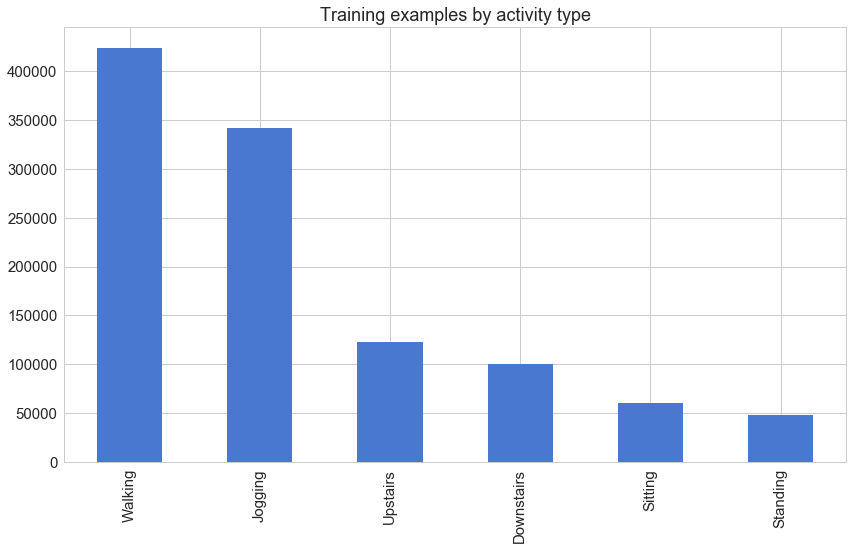

In [5]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

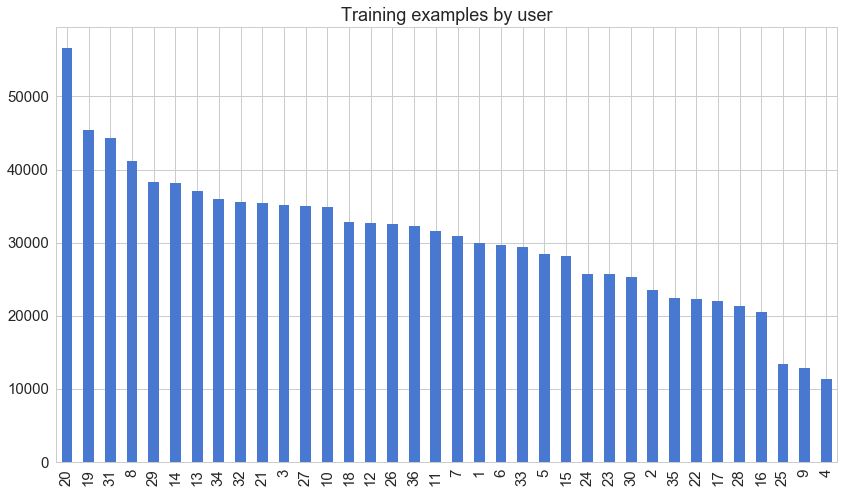

In [6]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');

I wonder whether or not number 4 received the same paycheck as number 20. Now, for some accelerometer data:

In [7]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

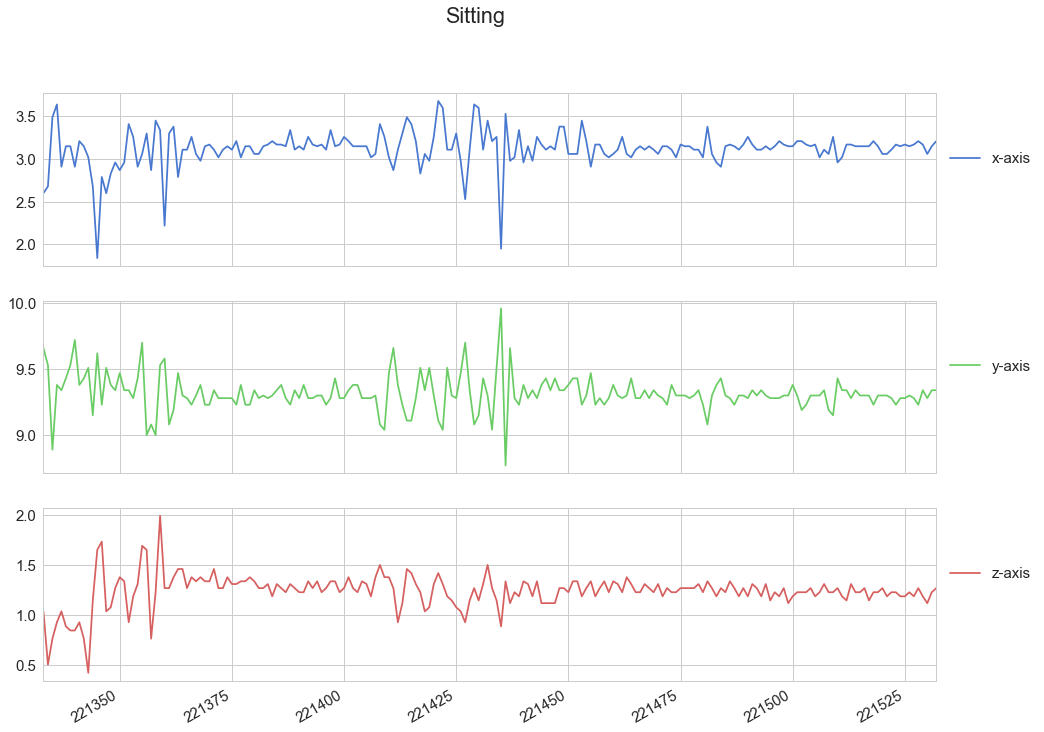

In [8]:
plot_activity("Sitting", df)

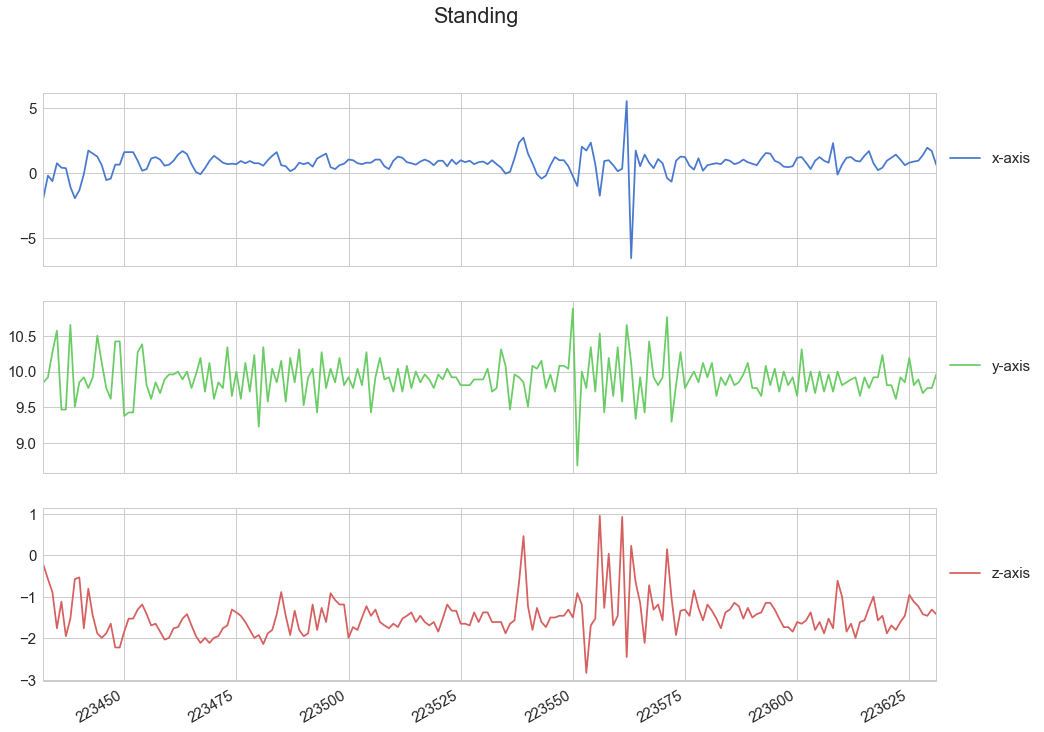

In [9]:
plot_activity("Standing", df)

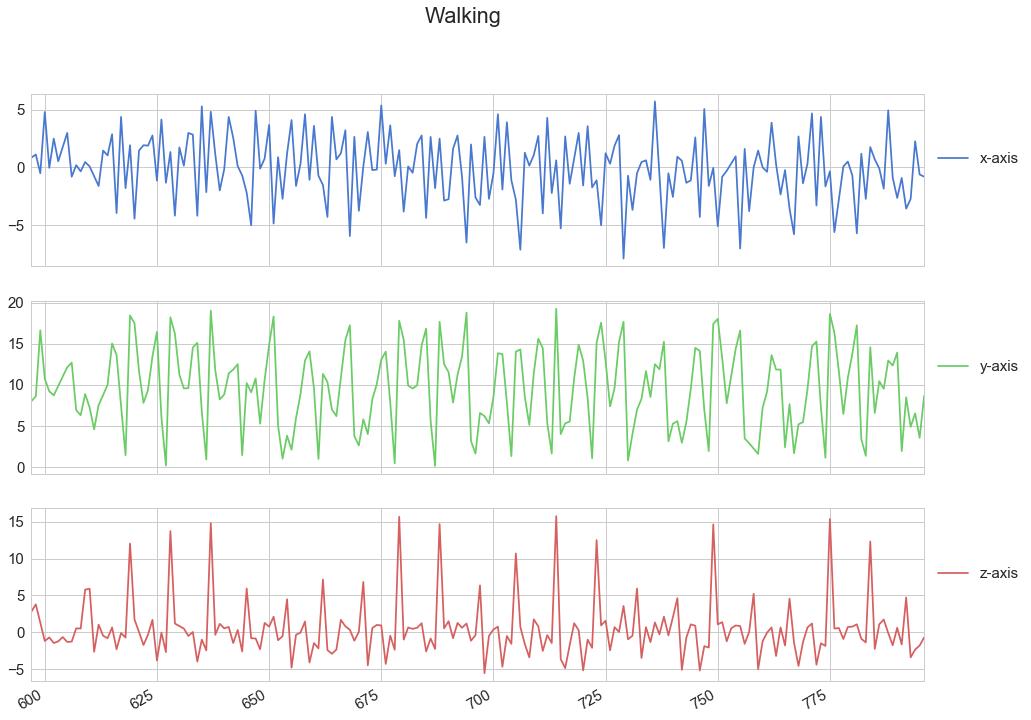

In [10]:
plot_activity("Walking", df)

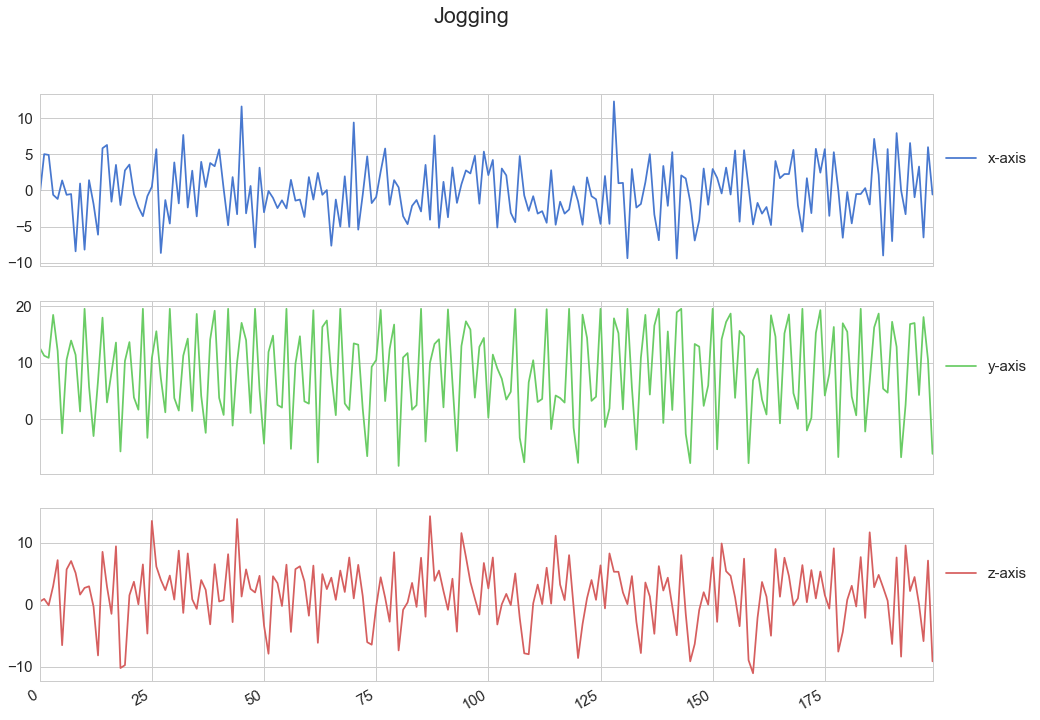

In [11]:
plot_activity("Jogging", df)

It seems reasonable to assume that this data might be used to train a model that can distinguish between the different kinds of activities. Well, at least the first 200 entries of each activity look that way.

# Data preprocessing

Our LSTM (covered in the previous part of the series) model expects fixed-length sequences as training data. We'll use a familiar method for generating these. Each generated sequence contains 200 training examples:

In [12]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

/Users/vini/.pyenv/versions/3.6.1/envs/curiousily_website/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [13]:
np.array(segments).shape

(54901, 3, 200)

Our training dataset has drastically reduced size after the transformation. Note that we take the most common activity and assign it as a label for the sequence. 

The shape of our tensor looks kinda strange. Let's transform it into sequences of 200 rows, each containing x, y and z. Let's apply a one-hot encoding to our labels, as well:

In [14]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [15]:
reshaped_segments.shape

(54901, 200, 3)

In [16]:
labels[0]

array([ 0.,  1.,  0.,  0.,  0.,  0.], dtype=float32)

Finally, let's split the data into training and test (20%) set:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [18]:
len(X_train)

43920

In [19]:
len(X_test)

10981

# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [20]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64

In [21]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

Now, let create placeholders for our model:

In [22]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:

In [23]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Again, we must properly name the tensor from which we will obtain predictions. We will use L2 regularization and that must be noted in our loss op:

In [24]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Finally, let's define optimizer and accuracy ops:

In [25]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

The training part contains a lot of TensorFlow boilerplate. We will train our model for 50 epochs and keep track of accuracy and error:

In [ ]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [ ]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.7736998796463013 loss: 1.2773654460906982
epoch: 10 test accuracy: 0.9388942122459412 loss: 0.5612533092498779
epoch: 20 test accuracy: 0.9574717283248901 loss: 0.3916512429714203
epoch: 30 test accuracy: 0.9693103432655334 loss: 0.2935260236263275
epoch: 40 test accuracy: 0.9747744202613831 loss: 0.2502188980579376


Whew, that was a lot of training. Do you feel thirsty? Let's store our precious model to disk:

In [ ]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

And loading it back:

In [31]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

# Evaluation

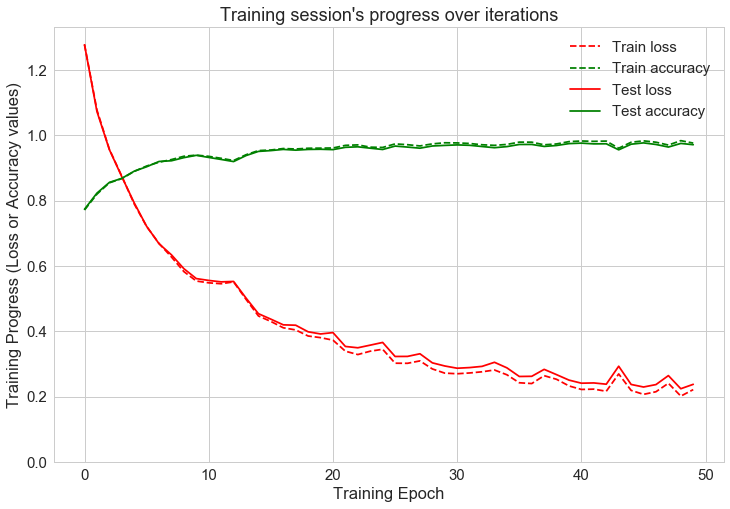

In [39]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

Our model seems to learn well with accuracy reaching above 97% and loss hovering at around 0.2. Let's have a look at the confusion matrix for the model's predictions:

In [40]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

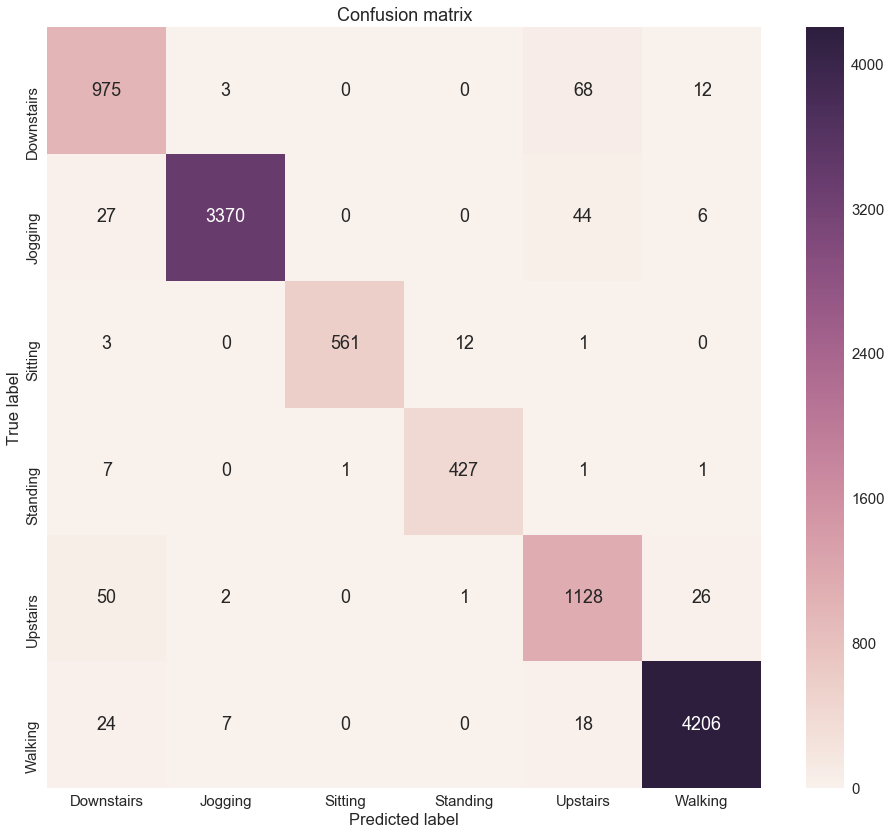

In [41]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

Again, it looks like our model performs real good. Some notable exceptions include the misclassification of  Upstairs for Downstairs and vice versa. Jogging seems to fail us from time to time as well!

# Exporting the model

Now that most of the hard work is done we must export our model in a way that TensorFlow for Android will understand it:

In [26]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
6862 ops in the final graph.


A sample app that uses the exported model can be found on [GitHub](https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/tree/master/AndroidApp). It is based heavily based on the [Activity Recognition](https://github.com/aqibsaeed/Human-Activity-Recognition-using-CNN/tree/master/ActivityRecognition) app by [Aaqib Saeed](https://aqibsaeed.github.io/). Our app uses the text-to-speech Android API to tell you what the model predicts at some interval and includes our pre-trained model.

The most notable parts of the Java code include defining our input and output dimensions and names:

```java
String INPUT_NODE = "inputs";
String[] OUTPUT_NODES = {"y_"};
String OUTPUT_NODE = "y_";
long[] INPUT_SIZE = {1, 200, 3};
int OUTPUT_SIZE = 6;
```

Creating the TensorFlowInferenceInterface:

```java
inferenceInterface = new TensorFlowInferenceInterface(context.getAssets(), MODEL_FILE);
```

And making the predictions:

```java
public float[] predictProbabilities(float[] data) {
    float[] result = new float[OUTPUT_SIZE];
    inferenceInterface.feed(INPUT_NODE, data, INPUT_SIZE);
    inferenceInterface.run(OUTPUT_NODES);
    inferenceInterface.fetch(OUTPUT_NODE, result);

    //Downstairs	Jogging	  Sitting	Standing	Upstairs	Walking
    return result;
}
```

The result is a float array that contains the probability for each possible activity, according to our model.

# Conclusion

We've built an LSTM model that can predict human activity from 200 time-step sequence with over 97% accuracy on the test set. The model was exported and used in an Android app. I had a lot of fun testing it on my phone, but it seems like more fine tuning (or changing the dataset) is required. Did you try the app? Can you improve it?

# References

- [CNN for Human Activity Recognition](https://github.com/aqibsaeed/Human-Activity-Recognition-using-CNN)
- [LSTMs for Human Activity Recognition](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)
- [Activity Recognition using Cell Phone Accelerometers](http://www.cis.fordham.edu/wisdm/public_files/sensorKDD-2010.pdf)
- [WIreless Sensor Data Mining Lab](http://www.cis.fordham.edu/wisdm/dataset.php)